# Distributed CBO -- Benchmark and Comparison

In [1]:
%load_ext autoreload
%autoreload 2

import math
import time

import matplotlib.pyplot as plt
import numpy as np

from cbx.dynamics import CBO, DistributedCBO
from cbx.objectives import Rastrigin, Ackley, Michalewicz
import cbx.utils.termination as term

# CBO Configuration

In [2]:
conf = {
    'alpha': 40.0,
    'dt': 0.1,
    'sigma': 1.,
    'lamda': 1.0,
    'term_criteria': [term.max_it_term(100)],
    'track_args': {'names': ['update_norm', 'energy', 'x', 'consensus', 'drift']},

    'noise': 'anisotropic',
    'f_dim': '3D'
}

# Define Benchmarking Functions

In [3]:
def benchmark_distributed_cbo(
    f: callable,
    num_runs: int,
    max_splitting_factor: int,
    max_particles: int,
    synchronization_interval: int,
    synchronization_method: str,
    num_steps: int,
    use_async_communication: bool = False,
    axs=None,
):  
    energy_means = []
    execution_times = []
    function_evaluations = []
    for splitting_factor in range(1, max_splitting_factor + 1):
        num_particles = math.ceil(max_particles / splitting_factor)
        energies = []
        for _ in range(num_runs):
            dyn = DistributedCBO(
                f=f,
                num_agent_batches=splitting_factor,
                synchronization_interval=synchronization_interval,
                synchronization_method=synchronization_method,
                use_async_communication=use_async_communication,
                N=num_particles,
                verbose=False,
                max_it=10000,
                **conf
            )

            # Run optimization and measure time
            tick = time.time()
            energies.append(
                f(dyn.optimize(num_steps=num_steps, sched='default'))
            )
            tock = time.time()
            execution_times.append(tock - tick)

            function_evaluations.append(dyn.num_f_eval())

        average_energy = np.median(energies)
        average_function_evaluations = np.mean(function_evaluations)
        print(f"Splitting factor: {splitting_factor}, average energy: {average_energy}, function evaluations: {average_function_evaluations}, execution time: {np.mean(execution_times)}")
        energy_means.append(average_energy)  

    if axs is not None:
        async_label = 'Async' if use_async_communication else 'Sync'
        axs.plot(list(range(1, max_splitting_factor + 1)), energy_means, label=f'Distributed CBO {async_label}')


In [4]:
def benchmark_standard_cbo(
    f: callable,
    num_runs: int,
    num_particles: int,
    axs=None,
):
    energies = []
    execution_times = []
    function_evaluations = []
    for _ in range(num_runs):
        dyn = CBO(
            f,
            N=num_particles,
            verbosity=0,
            max_it=10000,
            batch_args=None,
            M=1,
            **conf
        )

        # Run optimization and measure time
        tick = time.time()
        energies.append(
            f(dyn.optimize())
        )
        tock = time.time()
        execution_times.append(tock - tick)

        function_evaluations.append(dyn.num_f_eval)

    average_energy = np.median(energies)
    average_function_evaluations = np.mean(function_evaluations)
    print(f"Average energy: {average_energy}, function evaluations: {average_function_evaluations}, execution time: {np.mean(execution_times)}")

    # Plot mean of undistributed energies as a horizontal line
    if axs is not None:
        axs.axhline(y=average_energy, color='r', linestyle='--', label='Standard CBO')


# Benchmark

In [5]:
# Benchmarking params
NUM_RUNS = 200
MAX_SPLITTING_FACTOR = 10
MAX_PARTICLES = 100
SYNCHRONIZATION_INTERVAL = 10
SYNCHRONIZATION_METHOD = 'weighted_mean'

In [6]:
def run_experiment(
    f: callable,
    d: int,
    n: int
):
    fig, axs = plt.subplots(1, 1)

    conf['d'] = d
    # Baseline (standard CBO)
    print("Standard CBO:")
    print("=============")
    benchmark_standard_cbo(
        f=f,
        num_runs=NUM_RUNS,
        num_particles=n,
        axs=axs
    )
    print()

    # Synchronous
    print("Distributed CBO (synchronous communication):")
    print("=============================================")
    benchmark_distributed_cbo(
        f=f,
        use_async_communication=False,
        num_runs=NUM_RUNS,
        max_splitting_factor=MAX_SPLITTING_FACTOR,
        max_particles=n,
        synchronization_interval=SYNCHRONIZATION_INTERVAL,
        synchronization_method=SYNCHRONIZATION_METHOD,
        num_steps=1000000,   # Arbitrarily high number since we depend on the termination criteria
        axs=axs
    )
    print()

    # Asynchronous
    print("Distributed CBO (asynchronous communication):")
    print("==============================================")
    benchmark_distributed_cbo(
        f=f,
        use_async_communication=True,
        num_runs=NUM_RUNS,
        max_splitting_factor=MAX_SPLITTING_FACTOR,
        max_particles=n,
        synchronization_interval=SYNCHRONIZATION_INTERVAL,
        synchronization_method=SYNCHRONIZATION_METHOD,
        num_steps=100,
        axs=axs
    )
    print()

    function_label = f.__class__.__name__ + f" dim={d}"
    axs.set_xlabel(f"Splitting factor")
    axs.set_ylabel(f"Mean energy")
    axs.set_title(f"{function_label}\nsync interval: {SYNCHRONIZATION_INTERVAL}, sync method: {SYNCHRONIZATION_METHOD}, particles: {n}")
    axs.legend()
    
    fig.show()

## Ackley (d = 5, 10, 20; N = 50, 100, 200, 1000)

Standard CBO:
Average energy: 0.019836874657830794, function evaluations: 5050.0, execution time: 0.007809596061706543

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.021183015057492316, function evaluations: 5050.0, execution time: 0.015592259168624879
Splitting factor: 2, average energy: 0.01657060680413247, function evaluations: 5050.0, execution time: 0.018119874000549315
Splitting factor: 3, average energy: 0.018721658831128085, function evaluations: 5083.666666666667, execution time: 0.021797587076822916
Splitting factor: 4, average energy: 0.024636274349033815, function evaluations: 5125.75, execution time: 0.026507726609706878
Splitting factor: 5, average energy: 0.028346673901693098, function evaluations: 5110.6, execution time: 0.03052624011039734
Splitting factor: 6, average energy: 0.029121752504912113, function evaluations: 5167.833333333333, execution time: 0.035072341561317444
Splitting factor: 7, average energy: 0.032463888209717684,

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_62187/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


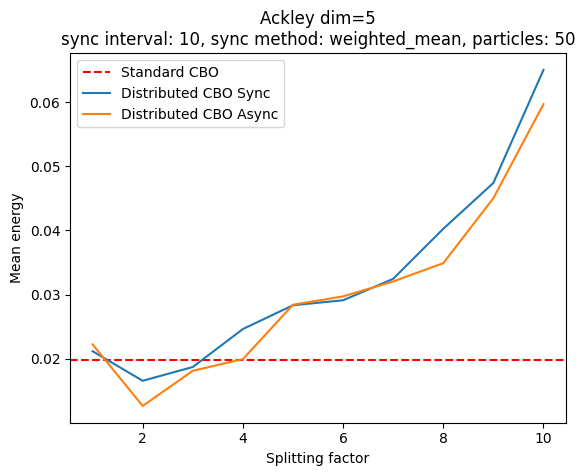

In [7]:
run_experiment(Ackley(), d=5, n=50)

Standard CBO:
Average energy: 0.13267862535136965, function evaluations: 5050.0, execution time: 0.008467057943344116

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.14258143878867324, function evaluations: 5050.0, execution time: 0.01638217568397522
Splitting factor: 2, average energy: 0.11144756779745757, function evaluations: 5050.0, execution time: 0.01885537087917328
Splitting factor: 3, average energy: 0.12123721687924638, function evaluations: 5083.666666666667, execution time: 0.02266424020131429
Splitting factor: 4, average energy: 0.1315658955547776, function evaluations: 5125.75, execution time: 0.02694886863231659
Splitting factor: 5, average energy: 0.16086512590809976, function evaluations: 5110.6, execution time: 0.03127913999557495
Splitting factor: 6, average energy: 0.16058353588285046, function evaluations: 5167.833333333333, execution time: 0.03569458305835724
Splitting factor: 7, average energy: 0.1665651884591992, function eval

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_62187/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


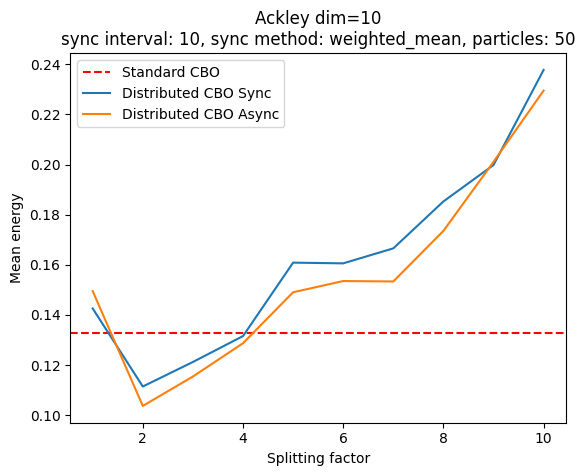

In [8]:
run_experiment(Ackley(), d=10, n=50)

Standard CBO:
Average energy: 0.43567647264876763, function evaluations: 5050.0, execution time: 0.009310958385467529

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.47864189583200245, function evaluations: 5050.0, execution time: 0.01751268148422241
Splitting factor: 2, average energy: 0.3800797394440889, function evaluations: 5050.0, execution time: 0.01995472013950348
Splitting factor: 3, average energy: 0.34151798346416173, function evaluations: 5083.666666666667, execution time: 0.02387765169143677
Splitting factor: 4, average energy: 0.38247730701358273, function evaluations: 5125.75, execution time: 0.028242648839950563
Splitting factor: 5, average energy: 0.42279878502264845, function evaluations: 5110.6, execution time: 0.03281341195106506
Splitting factor: 6, average energy: 0.40844494094341544, function evaluations: 5167.833333333333, execution time: 0.038357939720153805
Splitting factor: 7, average energy: 0.3937118410304028, function ev

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_62187/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


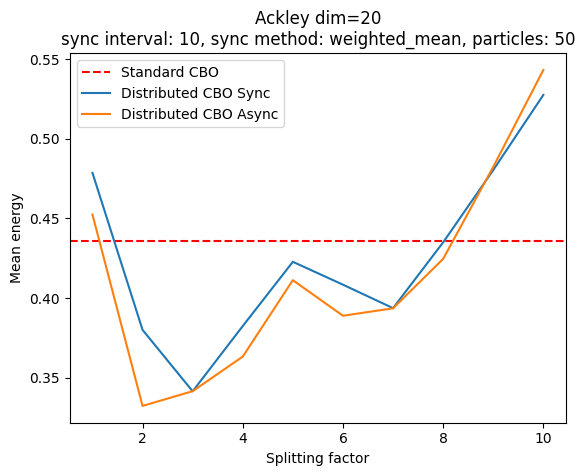

In [9]:
run_experiment(Ackley(), d=20, n=50)

Standard CBO:
Average energy: 0.010359755183829922, function evaluations: 10100.0, execution time: 0.008108625411987305

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.010456931331644714, function evaluations: 10100.0, execution time: 0.01662031888961792
Splitting factor: 2, average energy: 0.009483089431516323, function evaluations: 10100.0, execution time: 0.018796143531799318
Splitting factor: 3, average energy: 0.007658035891827897, function evaluations: 10167.333333333334, execution time: 0.02264057278633118
Splitting factor: 4, average energy: 0.008137725728899259, function evaluations: 10150.5, execution time: 0.02664854407310486
Splitting factor: 5, average energy: 0.009147101714452877, function evaluations: 10140.4, execution time: 0.0310162193775177
Splitting factor: 6, average energy: 0.009835383513508322, function evaluations: 10167.333333333334, execution time: 0.03558952808380127
Splitting factor: 7, average energy: 0.00990141355784013

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_62187/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


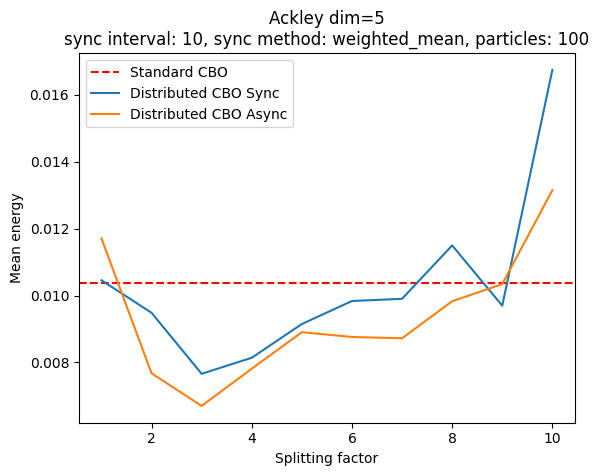

In [10]:
run_experiment(Ackley(), d=5, n=100)

Standard CBO:
Average energy: 0.057386095786953195, function evaluations: 10100.0, execution time: 0.009401228427886963

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.059251688916859724, function evaluations: 10100.0, execution time: 0.018510308265686035
Splitting factor: 2, average energy: 0.04678589218987783, function evaluations: 10100.0, execution time: 0.020574182868003846
Splitting factor: 3, average energy: 0.04962421297581665, function evaluations: 10167.333333333334, execution time: 0.024236682653427124
Splitting factor: 4, average energy: 0.05356965655723167, function evaluations: 10150.5, execution time: 0.028419505953788757
Splitting factor: 5, average energy: 0.06690424924240235, function evaluations: 10140.4, execution time: 0.032813647508621216
Splitting factor: 6, average energy: 0.06749370166886637, function evaluations: 10167.333333333334, execution time: 0.037683709263801574
Splitting factor: 7, average energy: 0.0672542318084965

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_62187/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


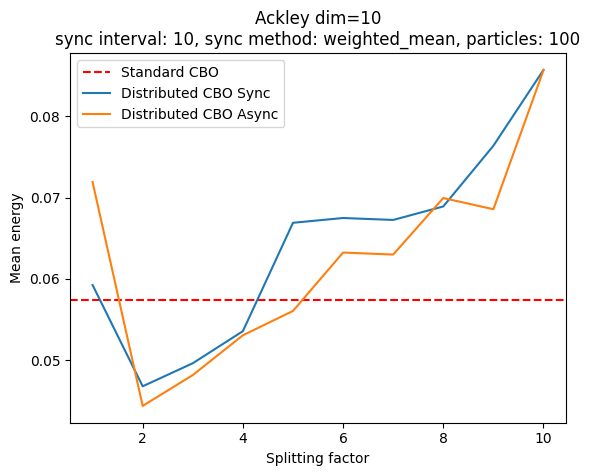

In [11]:
run_experiment(Ackley(), d=10, n=100)

Standard CBO:
Average energy: 0.2430210171601801, function evaluations: 10100.0, execution time: 0.011827819347381592

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.23907199632335407, function evaluations: 10100.0, execution time: 0.020265783071517943
Splitting factor: 2, average energy: 0.19168442530531715, function evaluations: 10100.0, execution time: 0.022960907220840453
Splitting factor: 3, average energy: 0.18097073319720502, function evaluations: 10167.333333333334, execution time: 0.027923264503479005
Splitting factor: 4, average energy: 0.1947673304625952, function evaluations: 10150.5, execution time: 0.0318181511759758
Splitting factor: 5, average energy: 0.20347652567614327, function evaluations: 10140.4, execution time: 0.03621649408340454
Splitting factor: 6, average energy: 0.19487880714725003, function evaluations: 10167.333333333334, execution time: 0.04212062060832977
Splitting factor: 7, average energy: 0.20550722732341642, funct

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_62187/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


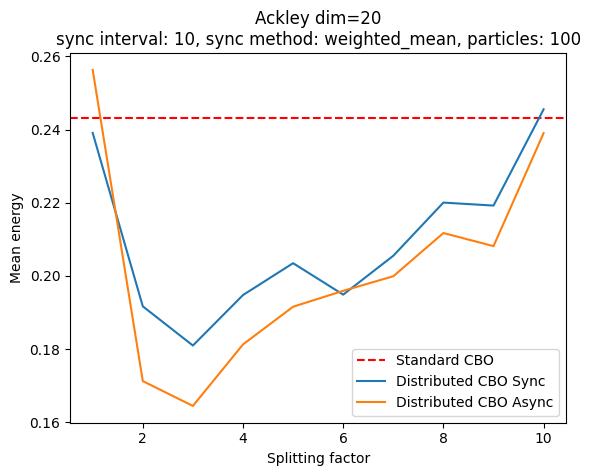

In [12]:
run_experiment(Ackley(), d=20, n=100)

Standard CBO:
Average energy: 0.0075942996512332606, function evaluations: 20200.0, execution time: 0.009924173355102539

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.007554366109666422, function evaluations: 20200.0, execution time: 0.01891432046890259
Splitting factor: 2, average energy: 0.00667853587553191, function evaluations: 20200.0, execution time: 0.021555444598197936
Splitting factor: 3, average energy: 0.006073214449433539, function evaluations: 20233.666666666668, execution time: 0.024649176994959512
Splitting factor: 4, average energy: 0.004829355602061103, function evaluations: 20225.25, execution time: 0.02846561461687088
Splitting factor: 5, average energy: 0.0044504817750259384, function evaluations: 20220.2, execution time: 0.0328102777004242
Splitting factor: 6, average energy: 0.003894594536119289, function evaluations: 20284.166666666668, execution time: 0.036934957305590314
Splitting factor: 7, average energy: 0.0043258278673

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_62187/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


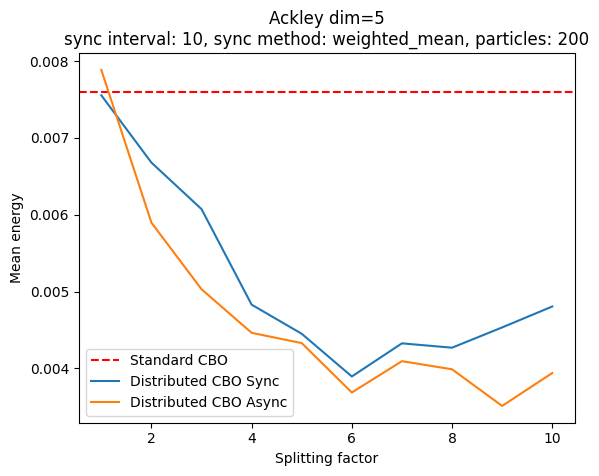

In [13]:
run_experiment(Ackley(), d=5, n=200)

Standard CBO:
Average energy: 0.03366792559466392, function evaluations: 20200.0, execution time: 0.011989083290100098

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.033066993001354295, function evaluations: 20200.0, execution time: 0.020910965204238893
Splitting factor: 2, average energy: 0.028410702023546452, function evaluations: 20200.0, execution time: 0.02549863338470459
Splitting factor: 3, average energy: 0.02681531506393897, function evaluations: 20233.666666666668, execution time: 0.029385501941045125
Splitting factor: 4, average energy: 0.02829934094011799, function evaluations: 20225.25, execution time: 0.032593232095241544
Splitting factor: 5, average energy: 0.0285576967050738, function evaluations: 20220.2, execution time: 0.03647218871116638
Splitting factor: 6, average energy: 0.028167075423058296, function evaluations: 20284.166666666668, execution time: 0.04061037282148997
Splitting factor: 7, average energy: 0.029682299878909024

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_62187/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


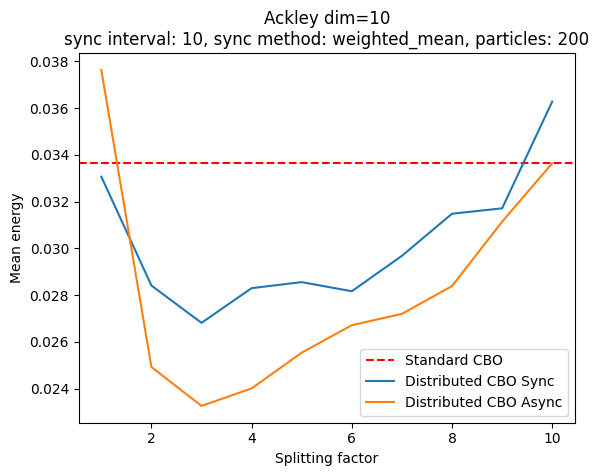

In [14]:
run_experiment(Ackley(), d=10, n=200)

Standard CBO:
Average energy: 0.1299674939449127, function evaluations: 20200.0, execution time: 0.01732688307762146

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.12980590747666243, function evaluations: 20200.0, execution time: 0.025072672367095948
Splitting factor: 2, average energy: 0.10410750301215055, function evaluations: 20200.0, execution time: 0.026909486651420594
Splitting factor: 3, average energy: 0.09887549720216038, function evaluations: 20233.666666666668, execution time: 0.031447607278823855
Splitting factor: 4, average energy: 0.09885861617788061, function evaluations: 20225.25, execution time: 0.03647970229387283
Splitting factor: 5, average energy: 0.1055212536155179, function evaluations: 20220.2, execution time: 0.04221608424186706
Splitting factor: 6, average energy: 0.10173488935831942, function evaluations: 20284.166666666668, execution time: 0.0480350661277771
Splitting factor: 7, average energy: 0.10921864155482064, funct

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_62187/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


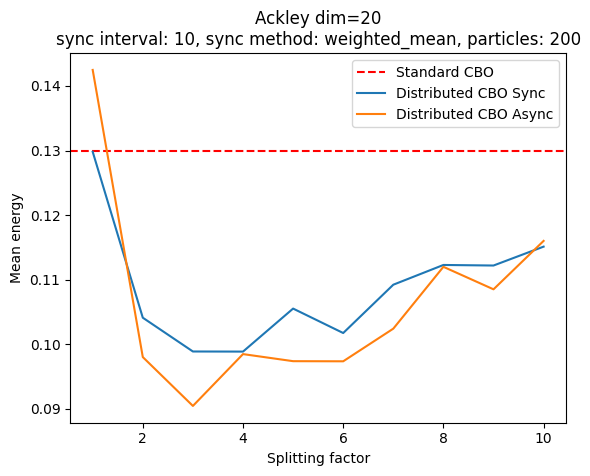

In [15]:
run_experiment(Ackley(), d=20, n=200)

Standard CBO:
Average energy: 0.0032405504843873167, function evaluations: 101000.0, execution time: 0.02651761770248413

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.002989963934533879, function evaluations: 101000.0, execution time: 0.035766525268554686
Splitting factor: 2, average energy: 0.003419487173566882, function evaluations: 101000.0, execution time: 0.035472424030303956
Splitting factor: 3, average energy: 0.0026885304284545164, function evaluations: 101067.33333333333, execution time: 0.04111852844556173
Splitting factor: 4, average energy: 0.002570559789282445, function evaluations: 101050.5, execution time: 0.046975177526473996
Splitting factor: 5, average energy: 0.0022655711305685777, function evaluations: 101040.4, execution time: 0.0536742250919342
Splitting factor: 6, average energy: 0.0023412798368611654, function evaluations: 101067.33333333333, execution time: 0.06122289359569549
Splitting factor: 7, average energy: 0.0018443

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_62187/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


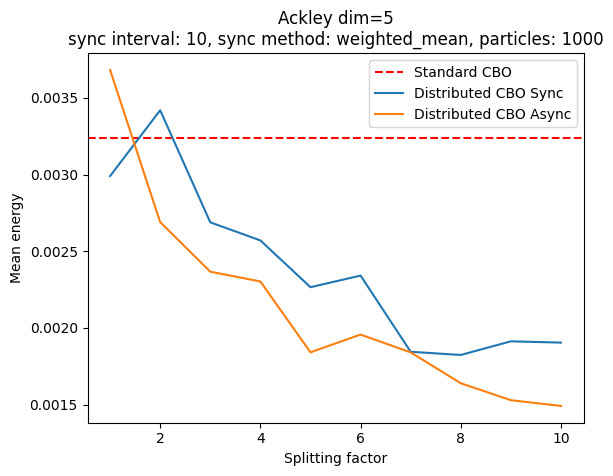

In [16]:
run_experiment(Ackley(), d=5, n=1000)

Standard CBO:
Average energy: 0.01883376364858913, function evaluations: 101000.0, execution time: 0.03596570014953613

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.01912727370421452, function evaluations: 101000.0, execution time: 0.045577222108840944
Splitting factor: 2, average energy: 0.017368330956316402, function evaluations: 101000.0, execution time: 0.04893718779087067
Splitting factor: 3, average energy: 0.014262258561946073, function evaluations: 101067.33333333333, execution time: 0.050833940108617144
Splitting factor: 4, average energy: 0.01294167639078525, function evaluations: 101050.5, execution time: 0.05539004743099213
Splitting factor: 5, average energy: 0.010983786135885243, function evaluations: 101040.4, execution time: 0.06160380578041077
Splitting factor: 6, average energy: 0.011398878448238836, function evaluations: 101067.33333333333, execution time: 0.0695289425055186
Splitting factor: 7, average energy: 0.011295136726293

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_62187/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


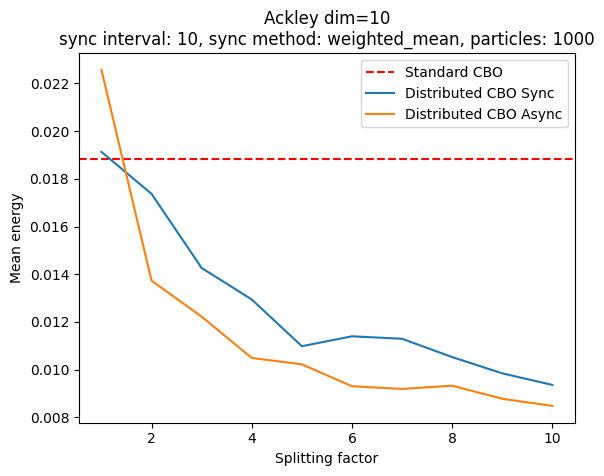

In [17]:
run_experiment(Ackley(), d=10, n=1000)

Standard CBO:
Average energy: 0.056322970577328935, function evaluations: 101000.0, execution time: 0.061071079969406125

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.057459285790662395, function evaluations: 101000.0, execution time: 0.07356375575065613
Splitting factor: 2, average energy: 0.04557873831798398, function evaluations: 101000.0, execution time: 0.06938794851303101
Splitting factor: 3, average energy: 0.04053122002750209, function evaluations: 101067.33333333333, execution time: 0.07465264042218527
Splitting factor: 4, average energy: 0.03768622956646839, function evaluations: 101050.5, execution time: 0.08207536876201629
Splitting factor: 5, average energy: 0.036104128750857445, function evaluations: 101040.4, execution time: 0.090908695936203
Splitting factor: 6, average energy: 0.03473861077609053, function evaluations: 101067.33333333333, execution time: 0.09855645835399628
Splitting factor: 7, average energy: 0.03392126348484448,

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_62187/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


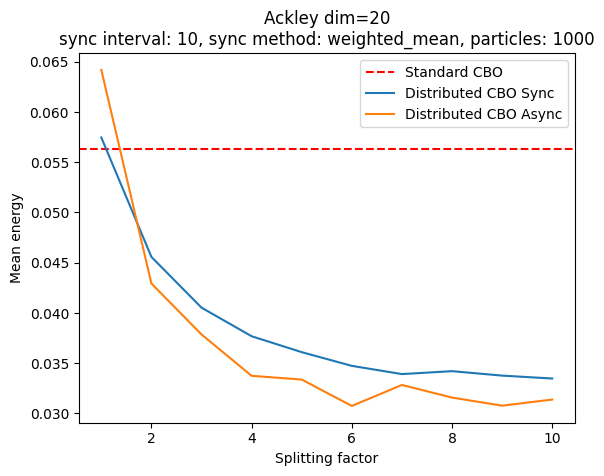

In [18]:
run_experiment(Ackley(), d=20, n=1000)